# Recurrent neural network

In [34]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## PREPARE DATA

### DATASET

Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

Monthly milk production: pounds per cow. Jan 62 - Dec 75

In [4]:
# Read data
milk = pd.read_csv('./Dataset/monthly-milk-production.csv', index_col='Month')
# Head of data
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


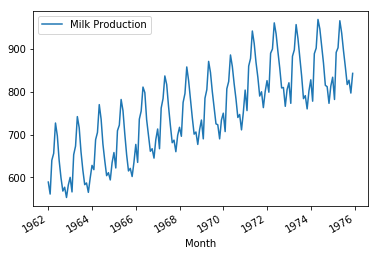

In [6]:
# Make the index a time series
milk.index = pd.to_datetime(milk.index)
# Plot data
milk.plot()

In [7]:
# Dataset info
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [11]:
# Split data for training and testing
train_set = milk.head(156)
test_set = milk.tail(12)
# Size of datasets
print(train_set.size)
print(test_set.size)

156
12


In [13]:
# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [14]:
# Function to generate next batch
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps. Then reshape this data to be (1,steps)

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN. Depending on your indexing it
    # will be either .reshape(-1,steps-1,1) or .reshape(-1,steps,1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

## CREATE MODEL

In [16]:
# Reset graph
tf.reset_default_graph()
# One feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer
num_neurons = 100
# One output, predicted time series
num_outputs = 1
# Learning rate
learning_rate = 0.001
# Number of iterations
num_train_iterations = 6000
# Size of the batch of data
batch_size = 1

In [17]:
# Placeholders
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])

In [18]:
# Create cell
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_neurons, activation=tf.nn.relu), output_size=num_outputs)
# Dynamin RNN
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [19]:
# Loss function
loss = tf.reduce_mean(tf.square(outputs-y))
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
# Minimize error
train = optimizer.minimize(loss)
# Initializer
init = tf.global_variables_initializer()

In [ ]:
# Create session
sess = tf.Session()
# Run initializer
sess.run(init)

# Training loop
for iteration in range(num_train_iterations):
    # Next batch
    batch_X, batch_y = next_batch(train_scaled,batch_size,num_time_steps)
    # Run training
    sess.run(train, feed_dict={X: batch_X, y: batch_y})

    # Display error every 100 steps
    if iteration % 100 == 0:
        # Grab error
        mse = sess.run(loss, feed_dict={X:batch_X, y:batch_y})
        # Print error
        print(iteration, "\tMSE:", mse)

In [26]:
# Create a numpy array for your seed from the last 12 months of the 
train_seed = list(train_scaled[-12:])

# Make predictions
for iteration in range(12):
    X_batch = np.array(
        train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
    y_pred = sess.run(outputs, feed_dict={X: X_batch})
    train_seed.append(y_pred[0, -1, 0])

train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.66118604,
 0.5473604,
 0.7825907,
 0.81735927,
 0.9596605,
 0.9053208,
 0.8195429,
 0.70660216,
 0.56660134,
 0.5663228,
 0.45641872,
 0.52596164]

In [35]:
# Results to DataFrame
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))
test_set['Generated'] = results
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,828.053406
1975-02-01 01:00:00,782.0,780.701904
1975-03-01 01:00:00,892.0,878.557678
1975-04-01 01:00:00,903.0,893.021423
1975-05-01 01:00:00,966.0,952.218750
1975-06-01 01:00:00,937.0,929.613464
1975-07-01 01:00:00,896.0,893.929810
1975-08-01 01:00:00,858.0,846.946472
1975-09-01 01:00:00,817.0,788.706177


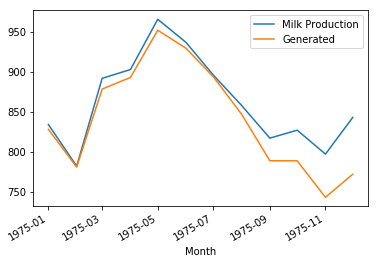

In [28]:
# Plot results
test_set.plot()